In [1]:
%matplotlib inline

from scipy.special import eval_hermite
import math
from matplotlib import pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import scipy.stats
from matplotlib.colors import Normalize
import os
from class_oscilloscope import *
from maxlike_skgc import maxlike
from wigner_fock import Wigner_fock
from filetree import FileTree
#from waveform import Waveform
#from waveloader import WaveLoader
from quadrature import QuadratureConverter, Quadrature
from easy_ui import ask_directory, input_is_yes

C:\Users\takas\Anaconda3\lib\site-packages\visa.py:23: FutureWarning: The visa module provided by PyVISA is being deprecated. You can replace `import visa` by `import pyvisa as visa` to achieve the same effect.

The reason for the deprecation is the possible conflict with the visa package provided by the https://github.com/visa-sdk/visa-python which can result in hard to debug situations.
  FutureWarning,


In [2]:
def pca(time_array):
    time_array = time_array - np.average(time_array)
    mat = time_array.T.dot(time_array)
    w,v = np.linalg.eigh(mat)
    return w[::-1], v[:,::-1]

def plot_bar3d_rho(rho):
    fig = plt.figure(figsize=(6, 3))
    ax1 = fig.add_subplot(121, projection='3d')
    X,Y = np.meshgrid(np.arange(rho.shape[0]), np.arange(rho.shape[1]))
    x,y,z = X.ravel(), Y.ravel(), np.zeros(X.size)

    dx,dy,dz_re = np.ones(X.size),np.ones(Y.size),np.real(rho).ravel()
    ax1.bar3d(x,y,z,dx,dy,dz_re)
    ax1.set_zlabel('Density matrix (real)')
    ax1.set_zlim(-1, 1)
    ax1.view_init(elev=10, azim=-60)

    ax2 = fig.add_subplot(122, projection='3d')
    dx,dy,dz_im = np.ones(X.size),np.ones(Y.size),np.imag(rho).ravel()
    ax2.bar3d(x,y,z,dx,dy,dz_im)
    ax2.set_zlabel("Density matrix (imag)")
    ax2.set_zlim(-1,1)
    ax2.view_init(elev=10, azim=-60)
    
def plot_wigner_rho(rho):
    w_pp = Wigner_fock(rho.shape[0]-1, 5, 0.01)
    x = np.linspace(-5, 5, 101)
    X,Y = np.meshgrid(x, x)
    wigner = w_pp.wigner_rho(rho, X, Y)
    f = plt.figure(figsize=(5,5))
    ax_3d = f.add_subplot(111, projection='3d')
#    ax_3d.plot_surface(X, Y, wigner)
    surf = ax_3d.plot_surface(X, Y, wigner.real, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    ax_3d.set_xlabel('X')
    ax_3d.set_ylabel('P')
    ax_3d.view_init(elev=90, azim=-90)
    f.colorbar(surf, shrink=0.5, aspect=5)
    return f, ax_3d

## インパルス応答確認

## データ指定

In [4]:
dir_name = r"C:\Users\takas\Desktop\OPA_cat\20210829_cat_FC_pump12mW_LO5mW_2"
os.makedirs(dir_name + "./analysis_result", exist_ok=True)
#phase = [0,15,30,45,60,75,90,105,120,135,150,165]
phase = [-90,-60,-30,0,30,60]

In [4]:
CN_test = WaveLoader.load([dir_name+"/0/trigger.wfm"], 'test_CN')

curves (test_CN) are loaded now.:   0%|                                                          | 0/1 [00:00<?, ?it/s]

C:\Users\Takase\Desktop\20210723_cat_FC_MZI_pump15mW_LO5mW_shape3_2/0/trigger .wfm


curves (test_CN) are loaded now.: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.62it/s]


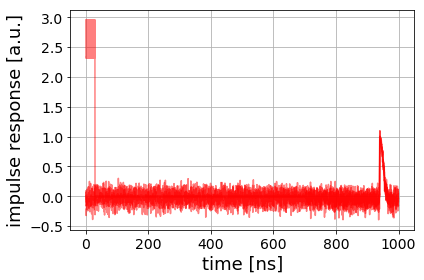

In [10]:
time = CN_test.time
signal_array = np.stack([curve for curve in CN_test.curves], axis=1)

for i in range(5):
    plt.plot(time*1e9,(signal_array[:,i]-np.average(signal_array[:,i]))*1e-4,color="red",alpha=0.5)

#plt.xlim(75,175)
plt.xlabel("time [ns]",fontsize=18)
plt.ylabel("impulse response [a.u.]",fontsize=18)
plt.grid()
#plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
#plt.savefig("overwright1.png",dpi=600)

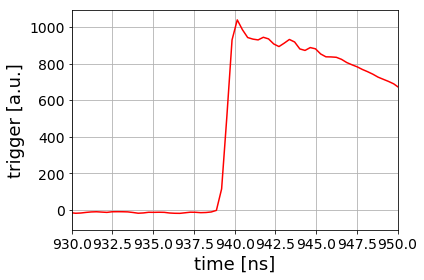

In [22]:
time = CN_test.time
signal_array = np.stack([curve for curve in CN_test.curves], axis=1)

trigger = np.zeros(len(signal_array[:,0]))
for i in range(1000):
    trigger = trigger + signal_array[:,i]-np.average(signal_array[:,i])

plt.plot(time*1e9,trigger*1e-4,color="red")
plt.xlim(930,950)
plt.xlabel("time [ns]",fontsize=18)
plt.ylabel("trigger [a.u.]",fontsize=18)
plt.grid()
#plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(dir_name + "./analysis_result/trigger2.png",dpi=300)

In [8]:
print(signal_array)

[[ 2628 -3946 -1820 ... -2400   -72 -4378]
 [    0 -4074 -1413 ... -1862   -28 -4494]
 [  162 -4187 -1097 ... -1213   -73 -4651]
 ...
 [-4684 -1523  -708 ...   180 -4976 -5506]
 [-4022 -1771 -1176 ...   190 -5424 -5903]
 [-3329 -1755 -1563 ...  -117 -5764 -6028]]


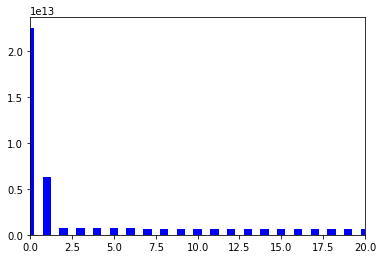

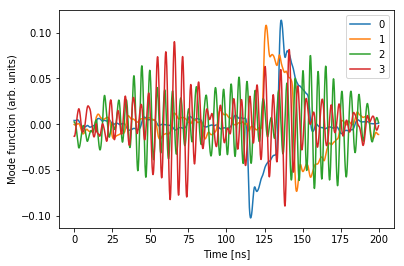

In [64]:
eig, modes = CN_test.pca()

plt.bar(np.arange(eig.size), eig, color='b', width=0.5)
plt.xlim(0, 20)
plt.show()

for i in range(4):
    plt.plot(CN_test.time * 1e9, modes[:, i], label=f'{i}')
plt.legend()
#plt.xlim(500,650)
plt.xlabel('Time [ns]')
plt.ylabel('Mode function (arb. units)')

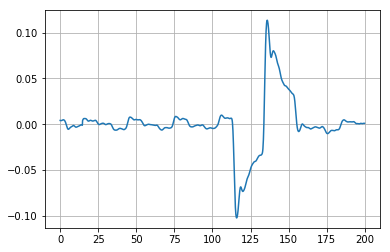

In [65]:
plt.plot(CN_test.time * 1e9, modes[:, 0])
plt.grid()
plt.savefig(dir_name + "./analysis_result/impulse_response.png",dpi=300)

## モード関数取得

In [4]:
phase_test = '90'
data_test = WaveLoader.load([dir_name+"/"+phase_test+"/HD.wfm"], 'test_data')
SN_test = WaveLoader.load([dir_name+"/"+phase_test+"/SN_HD.wfm"], 'test_SN')
CN_test = WaveLoader.load([dir_name+"/CN/CN_HD.wfm"], 'test_CN')

curves (test_SN) are loaded now.:   0%|                                                          | 0/1 [00:00<?, ?it/s]

C:\Users\Takase\Desktop\data\20210714_cat_FC_MZI_LO10mW_pump15mW_1/90/HD .wfm
C:\Users\Takase\Desktop\data\20210714_cat_FC_MZI_LO10mW_pump15mW_1/90/SN_HD .wfm


curves (test_CN) are loaded now.: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.58it/s]

C:\Users\Takase\Desktop\data\20210714_cat_FC_MZI_LO10mW_pump15mW_1/CN/CN_HD .wfm


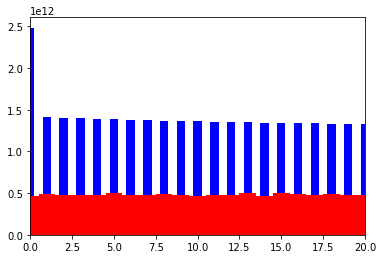

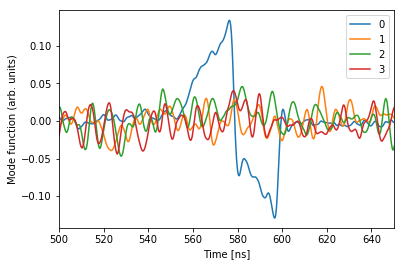

In [6]:
eig, modes = data_test.pca()

vac_array = np.stack([curve for curve in SN_test.curves], axis=1)
vac_array = vac_array - np.average(vac_array)
vac_array = vac_array.dot(vac_array.T)

vac_ref = modes.T.dot(vac_array).dot(modes)

plt.bar(np.arange(eig.size), eig, color='b', width=0.5)
plt.bar(np.arange(eig.size), np.diag(vac_ref), color='r', width=1)
plt.xlim(0, 20)
plt.show()

for i in range(4):
    plt.plot(data_test.time * 1e9, modes[:, i], label=f'{i}')
plt.legend()
plt.xlim(500,650)
plt.xlabel('Time [ns]')
plt.ylabel('Mode function (arb. units)')

In [7]:
wavepacket = modes[:,0]
np.save(dir_name+'/analysis_result/modefunction.npy', wavepacket)

## PCA

In [ ]:
if __name__ == '__main__':

    quads_pp = dict()

    if not input_is_yes(f'Calculate and plot quadratures?'):
        skip_calc = True
    else:
        skip_calc = False

    for ph in phase:

        if skip_calc:
            quads_pp[ph] = Quadrature.load(dir_name+str(ph)+'/HD', 'data').data
            continue

        pp = WaveLoader.load([dir_name+"/"+str(ph)+"/HD.wfm"], 'data')
        pp_sn = WaveLoader.load([dir_name+"/"+str(ph)+"/SN_HD.wfm"], 'SN')
        pp_cn = WaveLoader.load([dir_name+"/CN/CN_HD.wfm"], 'CN')

    #PCA
        eig, modes = pp.pca()

        vac_array = np.stack([curve for curve in pp_sn.curves], axis=1)
        vac_array = vac_array - np.average(vac_array)
        vac_array = vac_array.dot(vac_array.T)

        vac_ref = modes.T.dot(vac_array).dot(modes)
        
        plt.figure()
        plt.bar(np.arange(eig.size), eig, color='b', width=0.5)
        plt.bar(np.arange(eig.size), np.diag(vac_ref), color='r', width=1)
        plt.xlim(0, 20)
        plt.savefig(dir_name+'/analysis_result/pc'+str(ph)+'.png', dpi=300)
        
        plt.figure()
        for i in range(4):
            plt.plot(pp.time * 1e9, modes[:, i], label=f'{i}')
        plt.legend()
        plt.xlim(500,650)
        plt.xlabel('Time [ns]')
        plt.ylabel('Mode function (arb. units)')
        plt.savefig(dir_name+'/analysis_result/modefunction'+str(ph)+'.png', dpi=300)

    #Quadrature calculation
        wavepacket = np.load(dir_name+'/analysis_result/modefunction.npy')
        pp_quad = QuadratureConverter.convert(pp, pp_sn, pp_cn, mode_impulse=wavepacket[::-1])
        pp_quad.save(dir_name+'/'+str(ph))
        pp_quad.save(dir_name+'/analysis_result/'+str(ph))

        pp_data = pp_quad.data
        print(pp_data)
        plt.figure()
        plt.hist(pp_data, bins=100)
        plt.savefig(dir_name+'/analysis_result/pp_hist_'+str(ph)+'.png', dpi=300)

        quads_pp[ph] = pp_data

Calculate and plot quadratures?(y/n)
>>y


curves (SN) are loaded now.:   0%|                                                               | 0/1 [00:00<?, ?it/s]

C:\Users\Takase\Desktop\data\20210714_cat_FC_MZI_LO10mW_pump15mW_1/0/HD .wfm
C:\Users\Takase\Desktop\data\20210714_cat_FC_MZI_LO10mW_pump15mW_1/0/SN_HD .wfm


curves (CN) are loaded now.:   0%|                                                               | 0/1 [00:00<?, ?it/s]

C:\Users\Takase\Desktop\data\20210714_cat_FC_MZI_LO10mW_pump15mW_1/CN/CN_HD .wfm


curves (CN) are loaded now.: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.61it/s]


[ 0.56967133  0.03287485  0.42127341 ... -1.03068659  0.62868089
 -1.0826452 ]


curves (SN) are loaded now.:   0%|                                                               | 0/1 [00:00<?, ?it/s]

C:\Users\Takase\Desktop\data\20210714_cat_FC_MZI_LO10mW_pump15mW_1/15/HD .wfm
C:\Users\Takase\Desktop\data\20210714_cat_FC_MZI_LO10mW_pump15mW_1/15/SN_HD .wfm


curves (CN) are loaded now.:   0%|                                                               | 0/1 [00:00<?, ?it/s]

C:\Users\Takase\Desktop\data\20210714_cat_FC_MZI_LO10mW_pump15mW_1/CN/CN_HD .wfm


curves (CN) are loaded now.: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.11it/s]


[-0.07741349  0.20574999  0.81360265 ... -1.12438158 -0.3709201
  0.91703364]


curves (SN) are loaded now.:   0%|                                                               | 0/1 [00:00<?, ?it/s]

C:\Users\Takase\Desktop\data\20210714_cat_FC_MZI_LO10mW_pump15mW_1/30/HD .wfm
C:\Users\Takase\Desktop\data\20210714_cat_FC_MZI_LO10mW_pump15mW_1/30/SN_HD .wfm


curves (CN) are loaded now.: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.93it/s]


C:\Users\Takase\Desktop\data\20210714_cat_FC_MZI_LO10mW_pump15mW_1/CN/CN_HD .wfm
[-0.81153044  0.69318881  1.80914165 ... -0.52089173 -0.77792919
  1.39642972]


curves (SN) are loaded now.:   0%|                                                               | 0/1 [00:00<?, ?it/s]

C:\Users\Takase\Desktop\data\20210714_cat_FC_MZI_LO10mW_pump15mW_1/45/HD .wfm
C:\Users\Takase\Desktop\data\20210714_cat_FC_MZI_LO10mW_pump15mW_1/45/SN_HD .wfm


curves (CN) are loaded now.: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.30it/s]


C:\Users\Takase\Desktop\data\20210714_cat_FC_MZI_LO10mW_pump15mW_1/CN/CN_HD .wfm
[-1.49581865  1.08861237  0.60986426 ...  0.7124289  -2.11417539
 -0.87222954]


curves (SN) are loaded now.:   0%|                                                               | 0/1 [00:00<?, ?it/s]

C:\Users\Takase\Desktop\data\20210714_cat_FC_MZI_LO10mW_pump15mW_1/60/HD .wfm
C:\Users\Takase\Desktop\data\20210714_cat_FC_MZI_LO10mW_pump15mW_1/60/SN_HD .wfm


curves (CN) are loaded now.: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.51it/s]


C:\Users\Takase\Desktop\data\20210714_cat_FC_MZI_LO10mW_pump15mW_1/CN/CN_HD .wfm
[ 1.43323786 -0.20248826  1.50851847 ... -2.84499336 -1.04285039
  0.91567399]


curves (SN) are loaded now.:   0%|                                                               | 0/1 [00:00<?, ?it/s]

C:\Users\Takase\Desktop\data\20210714_cat_FC_MZI_LO10mW_pump15mW_1/75/HD .wfm
C:\Users\Takase\Desktop\data\20210714_cat_FC_MZI_LO10mW_pump15mW_1/75/SN_HD .wfm


curves (CN) are loaded now.: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.46it/s]


C:\Users\Takase\Desktop\data\20210714_cat_FC_MZI_LO10mW_pump15mW_1/CN/CN_HD .wfm
[ 1.34310576  1.39997414 -1.93003535 ...  1.87909543 -1.16016541
  0.06346739]


curves (SN) are loaded now.:   0%|                                                               | 0/1 [00:00<?, ?it/s]

C:\Users\Takase\Desktop\data\20210714_cat_FC_MZI_LO10mW_pump15mW_1/90/HD .wfm
C:\Users\Takase\Desktop\data\20210714_cat_FC_MZI_LO10mW_pump15mW_1/90/SN_HD .wfm


curves (CN) are loaded now.: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


C:\Users\Takase\Desktop\data\20210714_cat_FC_MZI_LO10mW_pump15mW_1/CN/CN_HD .wfm


## トモグラフィー

Tomography (postprocess)?(y/n)
>>y
(126012, 11, 11)
projection operator prepared
0 0.07824040782780137
1 0.036835901608697375
2 0.00972345540279393
3 0.0027796951070743867
4 0.0008746587040586894
5 0.0003098223193889826
6 0.0001267355660867197
7 6.006197926137409e-05
8 3.257400669852407e-05
9 1.972005547093395e-05
10 1.2965621760702027e-05
11 9.049916257195744e-06
12 6.599126927878112e-06
13 4.9742768527758825e-06
14 3.849562234940364e-06
15 3.0449297434771513e-06
16 2.454030232848371e-06
17 2.010606812889996e-06
18 1.6716104169442625e-06
19 1.4081315772571084e-06
20 1.2002411237668561e-06
21 1.033907165400403e-06
22 8.990759785048839e-07
23 7.884364288615168e-07
24 6.966021923366036e-07
25 6.195581091722973e-07
26 5.542783135266156e-07
27 4.984587344801853e-07
28 4.503272532018379e-07
29 4.085074552237636e-07
30 3.719198825622421e-07
31 3.397098315496748e-07
32 3.1119413156734624e-07
33 2.858216156376153e-07
34 2.6314354562576137e-07
35 2.427913270565252e-07
36 2.244595979136613e-07
3

313 3.366342158619903e-11
314 3.3008249724185383e-11
315 3.236714328198965e-11
316 3.1739771080112244e-11
317 3.112581041072552e-11
318 3.0524946769994864e-11
319 2.9936873632142404e-11
320 2.936129229996449e-11
321 2.8797911553509764e-11
322 2.824644760035918e-11
323 2.7706623768384814e-11
324 2.7178170333113608e-11
325 2.666082438550121e-11
326 2.6154329593333952e-11
327 2.565843602202375e-11
328 2.5172900009142225e-11
329 2.4697483917914862e-11
330 2.4231956089267087e-11
331 2.3776090549150548e-11
332 2.3329666999002844e-11
333 2.2892470529542367e-11
334 2.246429156676639e-11
335 2.204492570485583e-11
336 2.163417356571884e-11
337 2.1231840663419873e-11
338 2.083773729203029e-11
339 2.045167836214046e-11
340 2.0073483354266127e-11
341 1.970297610205296e-11
342 1.933998475579893e-11
343 1.8984341636742452e-11
344 1.8635883119020396e-11
345 1.8294449563381398e-11
346 1.7959885155867142e-11
347 1.7632037883941172e-11
348 1.7310759353127893e-11
349 1.6995904762603954e-11
350 1.668733277

625 2.0984533221522318e-13
626 2.067462660129275e-13
627 2.0369349241631882e-13
628 2.006863083276542e-13
629 1.977240212014649e-13
630 1.9480594939763709e-13
631 1.9193142350867162e-13
632 1.8909978123697582e-13
633 1.8631037424592297e-13
634 1.8356256162078962e-13
635 1.8085571271589638e-13
636 1.7818921059144507e-13
637 1.7556243928598364e-13
638 1.7297480186675794e-13
639 1.7042570523715132e-13
640 1.6791456576783446e-13
641 1.6544081046928542e-13
642 1.6300387484437764e-13
643 1.6060320051596607e-13
644 1.5823824402309462e-13
645 1.5590846270487544e-13
646 1.5361332656207378e-13
647 1.513523139913546e-13
648 1.4912491007250938e-13
649 1.4693060655906427e-13
650 1.4476890762902398e-13
651 1.4263931879171738e-13
652 1.4054135968568634e-13
653 1.3847455246890794e-13
654 1.3643842645248652e-13
655 1.3443252351588198e-13
656 1.3245638649882634e-13
657 1.3050956884372326e-13
658 1.285916292010943e-13
659 1.267021347615842e-13
660 1.248406574691645e-13
661 1.2300677577756205e-13
662 1.21

937 2.171747908760845e-15
938 2.140444291501265e-15
939 2.1095930458437903e-15
940 2.0791873746074883e-15
941 2.0492207868881513e-15
942 2.0196871525011537e-15
943 1.9905798784857662e-15
944 1.961893263150783e-15
945 1.9336207605571183e-15
946 1.9057564933349768e-15
947 1.8782948098155347e-15
948 1.8512294208603577e-15
949 1.8245550705843597e-15
950 1.7982656759426678e-15
951 1.7723559701150694e-15
952 1.7468202498966724e-15
953 1.7216533555091285e-15
954 1.6968496125478573e-15
955 1.6724040331250383e-15
956 1.6483113113359576e-15
957 1.6245663904356823e-15
958 1.6011641687199854e-15
959 1.578099691015097e-15
960 1.5553682502878358e-15
961 1.5329647679376213e-15
962 1.5108845599076413e-15
963 1.4891231656501972e-15
964 1.4676757549458413e-15
965 1.4465378441505242e-15
966 1.4257049482059857e-15
967 1.4051726544052435e-15
968 1.3849365768392314e-15
969 1.3649924812672175e-15
970 1.3453362085745131e-15
971 1.3259634749149227e-15
972 1.3068703479422128e-15
973 1.2880523904588325e-15
974 1

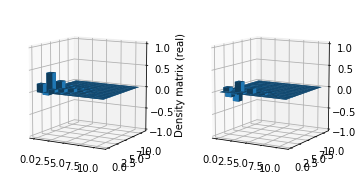

wavefunc instantiation end


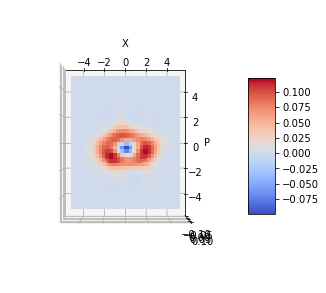

In [20]:
#Tomography
quadratures = []
phases = []
for key, value in quads_pp.items():
    quadratures.append(value)
    phases.append(key * np.ones(value.size) * np.pi/180)

if input_is_yes(f'Tomography (postprocess)?'):
    rho_pp = maxlike(np.array(quadratures).ravel(), np.array(phases).ravel(), max_photon=10, conv_th=1e-15)
    np.save(dir_name+'/analysis_result/rho.npy', rho_pp)
else:
    rho_pp = np.load(dir_name+'/analysis_result/rho.npy', rho_pp)
print(rho_pp)

plot_bar3d_rho(rho_pp)
#plt.savefig(f'{home_dir}/analysis_result/postprocess_rho.png', dpi=450)
plt.show()

fig, ax = plot_wigner_rho(rho_pp)
#plt.savefig(f'{home_dir}/analysis_result/postprocess_wigner.png', dpi=450)
plt.show()

ax.view_init(elev=0, azim = -90)
#plt.savefig(f'{home_dir}/analysis_result/postprocess_wigner_fromSide.png', dpi=450)
plt.show()

wavefunc instantiation end
(-0.11462925533355514+0j)


C:\Users\takas\Anaconda3\lib\site-packages\numpy\ma\core.py:2795: ComplexWarning: Casting complex values to real discards the imaginary part
  order=order, subok=True, ndmin=ndmin)


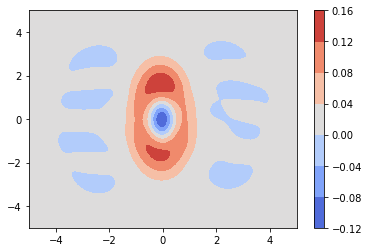

In [5]:
rho_pp = np.load(dir_name+'/analysis_result2/rho.npy')

w_pp = Wigner_fock(rho_pp.shape[0]-1, 5, 0.01)
x = np.linspace(-5, 5, 201)
X,Y = np.meshgrid(x, x)
wigner = w_pp.wigner_rho(rho_pp, X, Y)
plt.contourf(X, Y, wigner,cmap='coolwarm')
plt.colorbar()
print(wigner[100,100])
#plt.savefig(dir_name + "./analysis_result/wigner.png",dpi=300)

wavefunc instantiation end


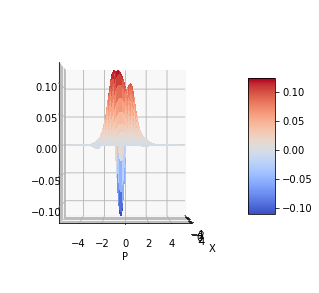

In [22]:
w_pp = Wigner_fock(rho_pp.shape[0]-1, 5, 0.01)
x = np.linspace(-5, 5, 201)
X,Y = np.meshgrid(x, x)
wigner = w_pp.wigner_rho(rho_pp, X, Y)
f = plt.figure(figsize=(5,5))
ax_3d = f.add_subplot(111, projection='3d')
#ax_3d.plot_surface(X, Y, wigner)
surf = ax_3d.plot_surface(X, Y, wigner.real, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax_3d.set_xlabel('X')
ax_3d.set_ylabel('P')
ax_3d.view_init(elev=0, azim=0)
f.colorbar(surf, shrink=0.5, aspect=5)
#plt.savefig(dir_name + "./analysis_result/wigner_side.png",dpi=300)

In [3]:
dir_name = r"C:\Users\takas\Desktop\OPA_cat\20210830_cat_FC_pump50mW_LO5mW"

In [3]:
# colormapをカスタマイズする
from matplotlib.colors import LinearSegmentedColormap

def generate_cmap(colors):
    """自分で定義したカラーマップを返す"""
    values = range(len(colors))

    vmax = np.ceil(np.max(values))
    color_list = []
    for v, c in zip(values, colors):
        color_list.append( ( v/ vmax, c) )
    return LinearSegmentedColormap.from_list('custom_cmap', color_list)

wavefunc instantiation end


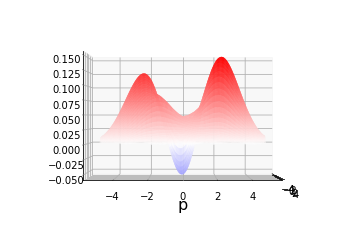

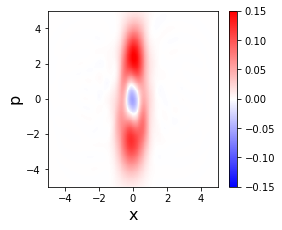

In [5]:
from matplotlib.colors import Normalize

rho_pp = np.load(dir_name+'/analysis_result2/rho.npy')

w_pp = Wigner_fock(rho_pp.shape[0]-1, 5, 0.01)
x = np.linspace(-5, 5, 201)
X,P = np.meshgrid(x, x)
Z = np.real(w_pp.wigner_rho(rho_pp, X, P))

cm = generate_cmap(['blue','white', 'red'])

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
sideview = ax.plot_surface(X, P, Z, cmap = cm, norm=Normalize(vmin=-0.15, vmax=0.15), lw=0.5, rstride=1, cstride=1)
ax.view_init(elev=0, azim=0)
#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_zticks([-0.15, 0, 0.15])
#ax.set_zlim(-0.15,0.15)
#plt.tick_params(labelsize=12,pad=16)
#ax.set_xlabel("x", fontsize=16)
ax.set_ylabel("p", fontsize=16)
#fig.colorbar(sideview,shrink = 0.6)
#plt.savefig("./figure/wigner_side_50mW.png",dpi=300)

#fig = plt.figure()
#ax = fig.add_subplot(111, projection="3d")
#ax.plot_surface(X, P, Z, cmap = cm, norm=Normalize(vmin=-0.15, vmax=0.15), lw=0.5, rstride=1, cstride=1)
#ax.view_init(elev=60, azim=70)

fig = plt.figure(figsize=(4, 3.3))
heatmap = plt.pcolormesh(X, P, Z, cmap=cm, norm=Normalize(vmin=-0.15, vmax=0.15))
fig.colorbar(heatmap)
#plt.xticks([-10,-5,0,5,10],fontsize=12)
#plt.yticks([-10,-5,0,5,10],fontsize=12)
#plt.ylim(-5,5)
#plt.title("W(0) = " + "{:.3f}".format(Z[int(points/2), int(points/2)]),fontsize=16)
plt.xlabel('x',fontsize=16)
plt.ylabel('p',fontsize=16)
plt.tight_layout()
#plt.savefig("./figure/wigner_top_50mW.png",dpi=300)

In [6]:
dir_name = r"C:\Users\takas\Desktop\0723_bin_analysis_result2"

In [4]:
# colormapをカスタマイズする
from matplotlib.colors import LinearSegmentedColormap

def generate_cmap(colors):
    """自分で定義したカラーマップを返す"""
    values = range(len(colors))

    vmax = np.ceil(np.max(values))
    color_list = []
    for v, c in zip(values, colors):
        color_list.append( ( v/ vmax, c) )
    return LinearSegmentedColormap.from_list('custom_cmap', color_list)

wavefunc instantiation end


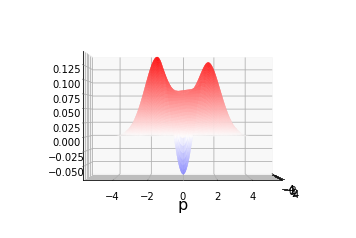

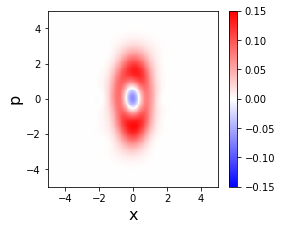

In [7]:
from matplotlib.colors import Normalize

rho_pp = np.load(dir_name+'/rho.npy')

w_pp = Wigner_fock(rho_pp.shape[0]-1, 5, 0.01)
x = np.linspace(-5, 5, 201)
X,P = np.meshgrid(x, x)
Z = np.real(w_pp.wigner_rho(rho_pp, X, P))

cm = generate_cmap(['blue','white', 'red'])

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
sideview = ax.plot_surface(X, P, Z, cmap = cm, norm=Normalize(vmin=-0.15, vmax=0.15), lw=0.5, rstride=1, cstride=1)
ax.view_init(elev=0, azim=0)
#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_zticks([-0.15, 0, 0.15])
#ax.set_zlim(-0.15,0.15)
#plt.tick_params(labelsize=12,pad=16)
#ax.set_xlabel("x", fontsize=16)
ax.set_ylabel("p", fontsize=16)
#fig.colorbar(sideview,shrink = 0.6)
plt.savefig(dir_name+'/wigner_side_.png')

#fig = plt.figure()
#ax = fig.add_subplot(111, projection="3d")
#ax.plot_surface(X, P, Z, cmap = cm, norm=Normalize(vmin=-0.15, vmax=0.15), lw=0.5, rstride=1, cstride=1)
#ax.view_init(elev=60, azim=70)

fig = plt.figure(figsize=(4, 3.3))
heatmap = plt.pcolormesh(X, P, Z, cmap=cm, norm=Normalize(vmin=-0.15, vmax=0.15))
fig.colorbar(heatmap)
#plt.xticks([-10,-5,0,5,10],fontsize=12)
#plt.yticks([-10,-5,0,5,10],fontsize=12)
#plt.ylim(-5,5)
#plt.title("W(0) = " + "{:.3f}".format(Z[int(points/2), int(points/2)]),fontsize=16)
plt.xlabel('x',fontsize=16)
plt.ylabel('p',fontsize=16)
plt.tight_layout()
plt.savefig(dir_name+'/wigner_top_.png')

## Journal figure

In [4]:
# colormapをカスタマイズする
from matplotlib.colors import LinearSegmentedColormap

def generate_cmap(colors):
    """自分で定義したカラーマップを返す"""
    values = range(len(colors))

    vmax = np.ceil(np.max(values))
    color_list = []
    for v, c in zip(values, colors):
        color_list.append( ( v/ vmax, c) )
    return LinearSegmentedColormap.from_list('custom_cmap', color_list)

def rotate(rho,theta):
    matrix = np.fromfunction(lambda i,j: np.exp(-1j*theta*(i-j)), rho.shape, dtype=complex)
    return rho*matrix

### cat

In [18]:
dir_name = r"C:\Users\takas\Desktop\OPA_cat\20210829_cat_FC_pump12mW_LO5mW_2\analysis_result2"

wavefunc instantiation end


C:\Users\takas\Anaconda3\lib\site-packages\matplotlib\figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


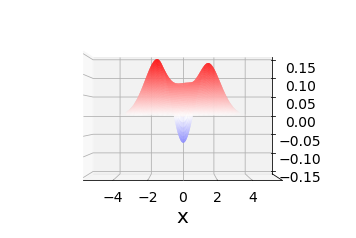

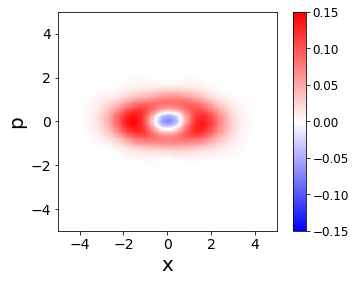

In [15]:
from matplotlib.colors import Normalize

theta = 90

rho_raw = np.load(dir_name+'/rho.npy')
rho_pp = rotate(rho_raw,theta/180*np.pi)

w_pp = Wigner_fock(rho_pp.shape[0]-1, 5, 0.01)
x = np.linspace(-5, 5, 201)
X,P = np.meshgrid(x, x)
Z = np.real(w_pp.wigner_rho(rho_pp, X, P))

cm = generate_cmap(['blue','white', 'red'])

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
sideview = ax.plot_surface(X, P, Z, cmap = cm, norm=Normalize(vmin=-0.15, vmax=0.15), lw=0.5, rstride=1, cstride=1)
ax.view_init(elev=0, azim=-90)
#ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([-0.15,-0.1,-0.05, 0,0.05,0.1, 0.15])
ax.set_zlim(-0.15,0.15)
plt.tick_params(axis="z",labelsize=14,pad=16)
plt.tick_params(axis="x",labelsize=14,pad=2)
ax.set_xlabel("x", fontsize=20,labelpad=16)
#ax.set_ylabel("p", fontsize=20, labelpad=16)
plt.savefig(dir_name+'/wigner_side_.png')

fig = plt.figure()
heatmap = plt.pcolormesh(X, P, Z, cmap=cm, norm=Normalize(vmin=-0.15, vmax=0.15))
plt.axis('square')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('x',fontsize=20)
plt.ylabel('p',fontsize=20)
cax = fig.add_axes((0.79, 0.19, 0.03, 0.76))
fig.colorbar(heatmap, cax = cax)
cax.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig(dir_name+'/wigner_top_.png')

In [16]:
print(np.min(np.ravel(Z)))

-0.06914204821422303


In [22]:
from scipy.special import comb

def add_loss(rho, l):
    rho_new = np.zeros((rho.shape[0],rho.shape[1]),dtype=complex)
    for i in range(rho.shape[0]):
        for j in range(rho.shape[1]):
            k = 0
            while i+k<rho.shape[0] and j+k<rho.shape[1]:
                if k==0:
                    rho_new[i][j] = rho[i][j]*(1-l)**((i+j)*0.5)
                    k += 1 
                else:
                    rho_new[i][j] += rho[i+k][j+k]*np.sqrt(comb(i+k, i, exact=True)*comb(j+k, j, exact=True))*(1-l)**((i+j)*0.5)*l**k
                    k += 1
    rho_new = rho_new/np.sum(np.diag(rho_new))
    return rho_new

In [31]:
l = 0.115

rho_raw = np.load(dir_name+'/rho.npy')
rho_pp = add_loss(rho_raw, l)

w_pp = Wigner_fock(rho_pp.shape[0]-1, 5, 0.01)
x = np.linspace(-5, 5, 201)
X,P = np.meshgrid(x, x)
Z = np.real(w_pp.wigner_rho(rho_pp, X, P))

wavefunc instantiation end


In [32]:
print(np.min(np.ravel(Z)))

-0.07008700745935921


### squeeze

In [37]:
dir_name = r"C:\Users\takas\Desktop\OPA_cat\rho_squeeze"

wavefunc instantiation end


C:\Users\takas\Anaconda3\lib\site-packages\matplotlib\figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


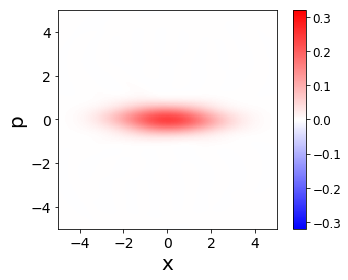

In [41]:
from matplotlib.colors import Normalize

theta = 90

rho_raw = np.load(dir_name+'/rho_squeeze_50mW.npy')
rho_pp = rotate(rho_raw,theta/180*np.pi)

w_pp = Wigner_fock(rho_pp.shape[0]-1, 5, 0.01)
x = np.linspace(-5, 5, 201)
X,P = np.meshgrid(x, x)
Z = np.real(w_pp.wigner_rho(rho_pp, X, P))

cm = generate_cmap(['blue','white', 'red'])

fig = plt.figure()
heatmap = plt.pcolormesh(X, P, Z, cmap=cm, norm=Normalize(vmin=-0.32, vmax=0.32))
plt.axis('square')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('x',fontsize=20)
plt.ylabel('p',fontsize=20)
cax = fig.add_axes((0.79, 0.19, 0.03, 0.76))
fig.colorbar(heatmap, cax = cax)
cax.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig(dir_name+'/wigner_50mW.png',dpi=300)

In [4]:
r = [0.33,0.458,0.640,0.915]

var_sq = [0.342,0.266,0.230,0.175]
var_sq = np.array(var_sq)
var_ansq = [0.856,1.084,1.471,2.526]
var_ansq = np.array(var_ansq)

l = 0.23
r_cont = np.arange(0,1.1,0.01)
sq = np.exp(-2*r_cont)/2*(1-l) + l/2
ansq = np.exp(2*r_cont)/2*(1-l) + l/2

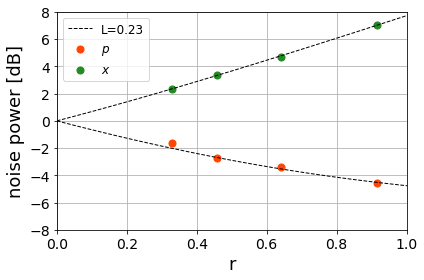

In [6]:
plt.plot(r_cont,10*np.log10(sq*2),"--",lw=1.,color="black")
plt.plot(r_cont,10*np.log10(ansq*2),"--",lw=1.,color="black",label="L=0.23")
plt.scatter(r,10*np.log10(var_sq*2),s=50,color="orangered",label=r"$p$")
plt.scatter(r,10*np.log10(var_ansq*2),s=50,color="forestgreen",label=r"$x$")
plt.xlim(0,1)
plt.ylim(-8,8)
plt.xlabel("r",fontsize=18)
plt.ylabel("noise power [dB]",fontsize=18)
plt.grid()
plt.legend(fontsize=12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig("./figure/squeezing_lebel.png",dpi=300)

In [72]:
10*np.log10(np.exp(-2*0.9))

-7.817300674258533

In [41]:
dir_name = r"C:\Users\takas\Desktop\TME_data\0718_DCreject_analysis_result2"
phase = [-60,-30,0,30,60,90]

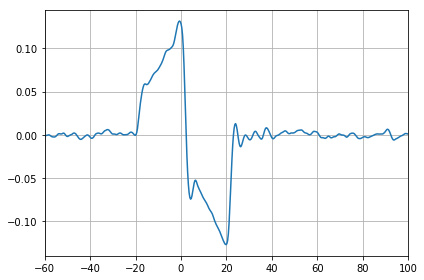

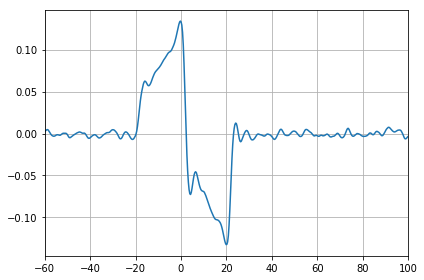

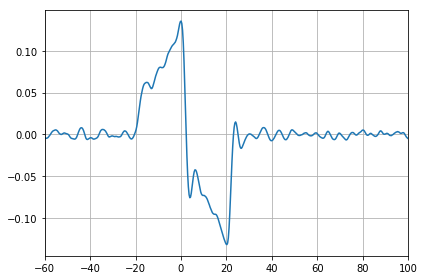

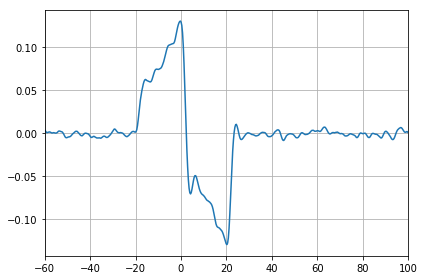

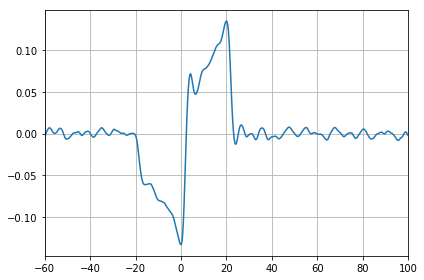

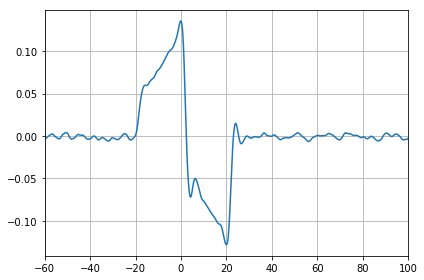

In [42]:
time = np.arange(0,1000,1/3.125)-503
for i in range(len(phase)):
    mode = np.load(dir_name+"/modefunction"+str(phase[i])+".npy")
    plt.figure()
    plt.plot(time,mode)
    plt.xlim(-60,100)
    plt.grid()
    plt.tight_layout()
    plt.savefig(dir_name + "/modefunction"+str(phase[i]))

In [7]:
mode.shape

(3125,)

In [10]:
time = np.arange(0,1000,1/3.125)
time.shape

(3125,)

wavefunc instantiation end


C:\Users\takas\Anaconda3\lib\site-packages\matplotlib\figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


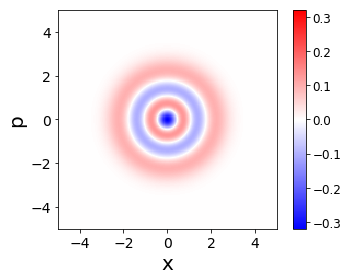

In [14]:
rho_pp = np.zeros((5,5))
rho_pp[3][3] = 1

w_pp = Wigner_fock(rho_pp.shape[0]-1, 5, 0.01)
x = np.linspace(-5, 5, 201)
X,P = np.meshgrid(x, x)
Z = np.real(w_pp.wigner_rho(rho_pp, X, P))

cm = generate_cmap(['blue','white', 'red'])

fig = plt.figure()
heatmap = plt.pcolormesh(X, P, Z, cmap=cm, norm=Normalize(vmin=-0.32, vmax=0.32))
plt.axis('square')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('x',fontsize=20)
plt.ylabel('p',fontsize=20)
cax = fig.add_axes((0.79, 0.19, 0.03, 0.76))
fig.colorbar(heatmap, cax = cax)
cax.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig('./figure/wigner_3.png')

In [26]:
10*np.log10(np.exp(2*0.58))

5.037815990077721

C:\Users\takas\Anaconda3\lib\site-packages\matplotlib\figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


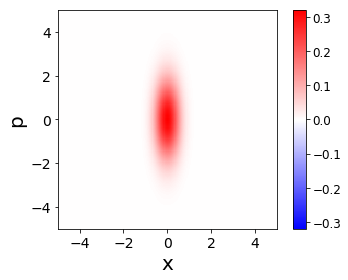

In [27]:
x = np.linspace(-5, 5, 201)
X,P = np.meshgrid(x, x)
r = 0.58
Z = np.exp(-np.exp(2*r)*X**2-np.exp(-2*r)*P**2)/np.pi

cm = generate_cmap(['blue','white', 'red'])

fig = plt.figure()
heatmap = plt.pcolormesh(X, P, Z, cmap=cm, norm=Normalize(vmin=-0.32, vmax=0.32))
plt.axis('square')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.grid()
plt.xlabel('x',fontsize=20)
plt.ylabel('p',fontsize=20)
cax = fig.add_axes((0.79, 0.19, 0.03, 0.76))
fig.colorbar(heatmap, cax = cax)
cax.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig('./figure/wigner_sq.png')

C:\Users\takas\Anaconda3\lib\site-packages\matplotlib\figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


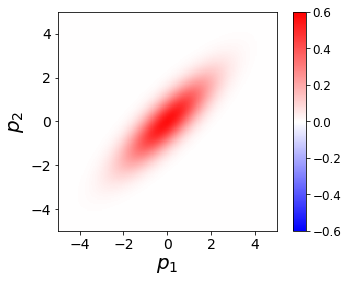

In [34]:
x = np.linspace(-5, 5, 201)
X,P = np.meshgrid(x, x)
r = 0.58
Z1 = np.exp(-np.exp(2*r)*(X+P)**2/4-np.exp(-2*r)*(X-P)**2/4)/np.sqrt(np.pi)
Z2 = np.exp(-np.exp(2*r)*(X-P)**2/4-np.exp(-2*r)*(X+P)**2/4)/np.sqrt(np.pi)

cm = generate_cmap(['blue','white', 'red'])

fig = plt.figure()
heatmap = plt.pcolormesh(X, P, Z2, cmap=cm, norm=Normalize(vmin=-0.6, vmax=0.6))
plt.axis('square')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.grid()
plt.xlabel(r'$p_1$',fontsize=20)
plt.ylabel(r'$p_2$',fontsize=20)
cax = fig.add_axes((0.79, 0.19, 0.03, 0.76))
fig.colorbar(heatmap, cax = cax)
cax.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig('./figure/EPR_p.png')

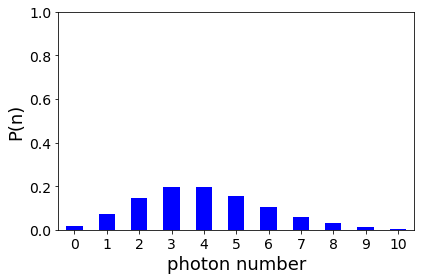

In [53]:
a = 2
n = np.arange(0,11,1)
n_dist = [np.exp(-a**2)*a**(2*n[i])/math.factorial(n[i]) for i in range(len(n))]

plt.bar(n, n_dist, color='b', width=0.5)
plt.xticks(np.arange(0,11,1))
plt.xlim(-0.5,10.5)
plt.ylim(0,1)
plt.xlabel('photon number',fontsize=18)
plt.ylabel('P(n)',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig('./figure/Pn_a1.png')

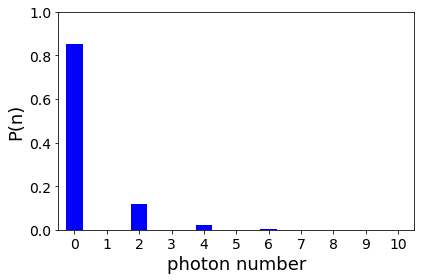

In [5]:
r = 0.58
n = np.arange(0,21,1)
n_dist = np.zeros(len(n))
for i in range(len(n)):
    if n[i]%2==0:
        n_dist[i] = math.factorial(n[i])/(math.factorial(n[i]/2))**2*(np.tanh(r)/2)**(n[i])/np.cosh(r)


plt.bar(n, n_dist, color='b', width=0.5)
plt.xticks(np.arange(0,11,1))
plt.xlim(-0.5,10.5)
plt.ylim(0,1)
plt.xlabel('photon number',fontsize=18)
plt.ylabel('P(n)',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig('./figure/Pn_r058.png')

In [56]:
10*np.log10(np.exp(2*0.35))

3.0400613733227635